In [1]:
import os
from os.path import join
import numpy as np
import json
import pickle
from transformers import BertTokenizer
from PIL import Image, ImageOps
import scipy.io
#import cv2
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [ ]:
# Latex font
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
#matplotlib.use('PS')

In [ ]:
amt_data_dir = "/home/zdai/repos/EgoTransformer/Data/amt_data/"
ana_file = join('Data', 'deepdiary_data', 'lifelog', 'dataset.json')
vocab_file = join('Data', 'data', 'vocabulary.p')

## Deepdiary Image-Caption pairs

In [ ]:
with open(ana_file, "r") as file:
    ana = json.load(file)

In [ ]:
ana['images'][0]

In [ ]:
img_305 = []
imgids = []

for img_name in os.listdir(amt_data_dir):
    for img_dict in ana['images']:
        if img_name == img_dict['filename']:
            img_305.append(img_dict)
            imgids.append(img_dict['imgid'])
            
print(len(imgids), len(img_305))

### Use 'amt_list.txt' directly

In [ ]:
with open(join(amt_data_dir, 'amt_list.txt'), "r") as file:
    pairs_str = file.read()
    pairs = pairs_str.split('\n')[1:]
len(pairs)

In [ ]:
img_names = {}

for pair in pairs:
    img_name = pair.split(' ')[0]
    sent_ana = pair.split('.jpg ')[-1]
    
    if img_name not in img_names:
        img_names[img_name] = [sent_ana]
    else:
        img_names[img_name].append(sent_ana)
        
len(img_names.items())

In [ ]:
my_idx = 50
for idx, (key, val) in enumerate(img_names.items()):
    if idx == my_idx:
        img_name0, cap_lst0 = key, val

image0 = Image.open(join(amt_data_dir, img_name0))
# Transpose with respect to EXIF data
image0 = ImageOps.exif_transpose(image0)
w, h = image0.size
print("PIL Image width: {}, height: {}".format(w, h))

plt.imshow(image0)
plt.show()
print(cap_lst0)

In [ ]:
img_names

## Deepdiary VGG16 features & caption pairs

In [ ]:
diary_data_dir = "/home/zdai/repos/EgoTransformer/Data/deepdiary_data/lifelog"
diary_ann = join(diary_data_dir, 'dataset.json')
diary_data = join(diary_data_dir, 'vgg_feats.mat')

In [ ]:
diary_mat = scipy.io.loadmat(diary_data)
diary_mat.keys()

In [ ]:
diary_mat['feats'][:50, 0]

In [ ]:
diary_mat['feats'].shape

In [ ]:
(diary_mat['feats'][:, -7] == diary_mat['feats'][:, -9]).all()

In [ ]:
with open(diary_ann, "r") as file:
    diary_anns = json.load(file)
len(diary_anns['images'])

In [ ]:
diary_anns['images'][-1]

In [ ]:
diary_pairs = diary_anns['images'].copy()

In [ ]:
index = 0
ann_pairs = []
last_sent0, last_sent_1 = '', ''

for idx, item in enumerate(diary_anns['images']):
    
    if item['sentences'][0]['raw'] == last_sent0 and item['sentences'][-1]['raw'] == last_sent_1:
        diary_pairs[idx]['segment'] = index
        
        tup[0].append(diary_mat['feats'][:, idx])
        
    else:
        last_sent0 = item['sentences'][0]['raw']
        last_sent_1 = item['sentences'][-1]['raw']
        
        if idx != 0:
            ann_pairs.append(tup)
            del tup
        
        index += 1
        diary_pairs[idx]['segment'] = index
        
        # tuple of (vgg_feature_vec, [captions])
        caps = [sent['raw'] for sent in item['sentences']]
        tup = ([diary_mat['feats'][:, idx]], caps)
    
    diary_pairs[idx]['feats'] = diary_mat['feats'][:, idx]

In [ ]:
ann_pairs[-1]

In [ ]:
with open(join(diary_data_dir, 'diary_pairs.pkl'), 'wb') as a_file:
    pickle.dump(diary_pairs, a_file)

In [ ]:
### Loading ###
with open(join(diary_data_dir, 'diary_pairs.pkl'), 'rb') as a_file:
    diary_pairs = pickle.load(a_file)

In [ ]:
with open(join(diary_data_dir, 'ann_pairs.pkl'), 'wb') as a_file:
    pickle.dump(ann_pairs, a_file)

In [ ]:
### Loading ###
with open(join(diary_data_dir, 'ann_pairs.pkl'), 'rb') as a_file:
    ann_pairs = pickle.load(a_file)

In [ ]:
ann_pairs[-1]

## MSVD

In [ ]:
msvd_data_dir = "/home/zdai/repos/MSVD"
msvd_ana_file = join(msvd_data_dir, 'AllVideoDescriptions.txt')
skipped_dir = join(msvd_data_dir, 'skipped')

In [ ]:
pairs = []

with open(msvd_ana_file, "r") as file:
    lines = file.readlines()
    print("Num of lines = ", len(lines))
    for line in lines:
        if line != "\n" and line[0] != "#":
            pairs.append(line)
len(pairs)

In [ ]:
vid_anns = {}
min_frame_per_clip = 5

for pair in pairs:
    img_name = pair.split(' ')[0]
    sent_ana = pair[len(img_name) + 1:-1]
    
    if img_name not in vid_anns:
        # Create a list of [path_to_image]
        img_keys = []
        # Discard clip with less than N frames
        if len(os.listdir(join(skipped_dir, img_name))) < min_frame_per_clip:
            continue
        
        for frame in sorted(os.listdir(join(skipped_dir, img_name)), key=lambda x: int(x.split('.')[0][6:])):
            #print(frame)
            img_keys.append(join(skipped_dir, img_name, frame))
        #show_img(img_keys[0])
        
        vid_anns[img_name] = (img_keys, [sent_ana])
    else:
        if sent_ana in vid_anns[img_name][1]:
            continue
        vid_anns[img_name][1].append(sent_ana)
        
len(vid_anns)

In [ ]:
def show_img(path_to_img):
    image0 = Image.open(path_to_img)
    # Transpose with respect to EXIF data
    image0 = ImageOps.exif_transpose(image0)
    w, h = image0.size
    print("PIL Image width: {}, height: {}".format(w, h))

    plt.imshow(image0)
    plt.show()

In [ ]:
vid_anns

In [ ]:
Anns = []

for idx, (key, val) in enumerate(vid_anns.items()):
    for index in range(len(val[1])):
        for i in range(len(val[0]) - min_frame_per_clip + 1):
            tuple_item = (val[0][i:i + min_frame_per_clip], val[1][index])
            Anns.append(tuple_item)

len(Anns)

In [ ]:
# Exhaustive selection
import random
window_frame_per_clip = 5
Anns_train, Anns_test = [], []

In [ ]:
X_train, X_test = train_test_split(list(vid_anns.keys()), test_size=0.3, random_state=123, shuffle=True)

for idx, (key, val) in enumerate(vid_anns.items()):
    
    for i in range(len(val[0]) - window_frame_per_clip + 1):
        
        tuple_item = (val[0][i:i + window_frame_per_clip], random.choice(val[1]))
        # Split vid_anns based on whether vid_name in X_train/X_test lists
        if key in X_train:
            Anns_train.append(tuple_item)
        elif key in X_test:
            Anns_test.append(tuple_item)
            
        # Break to avoid sample too many from long clips
        if i > 15:
            break

In [ ]:
print(len(Anns_train), len(Anns_test))

In [ ]:
len(Anns)

### Load with Function

In [ ]:
from sklearn.model_selection import train_test_split

def read_msvd(msvd_ana_file, skipped_dir, min_frame_per_clip=7, window_frame_per_clip=5):
    # TODO: split MSVD into train / test
    pairs, Anns_train, Anns_test = [], [], []
    vid_anns = {}
    
    assert window_frame_per_clip <= min_frame_per_clip

    with open(msvd_ana_file, "r") as file:
        lines = file.readlines()
        print("Num of lines = ", len(lines))
        for line in lines:
            if line != "\n" and line[0] != "#":
                pairs.append(line)

    for pair in pairs:
        img_name = pair.split(' ')[0]
        sent_ana = pair[len(img_name) + 1:-1]

        if img_name not in vid_anns:
            # Create a list of [path_to_image]
            img_keys = []
            # Discard clip with less than N frames
            if len(os.listdir(join(skipped_dir, img_name))) < min_frame_per_clip:
                continue

            for frame in sorted(os.listdir(join(skipped_dir, img_name)), key=lambda x: int(x.split('.')[0][6:])):
                img_keys.append(join(skipped_dir, img_name, frame))

            vid_anns[img_name] = (img_keys, [sent_ana])
        else:
            if sent_ana in vid_anns[img_name][1]:
                continue
            vid_anns[img_name][1].append(sent_ana)
    
    # vid_anns is a dict of {'vid_name': (['img1.jpg', 'img2.jpg' ...], ['cap1', 'cap2' ...]), ... ...}
    #print(next(iter(vid_anns)))
    X_train, X_test = train_test_split(list(vid_anns.keys()), test_size=0.3, random_state=42, shuffle=True)

    for idx, (key, val) in enumerate(vid_anns.items()):
        for index in range(len(val[1])):
            for i in range(len(val[0]) - window_frame_per_clip + 1):
                tuple_item = (val[0][i:i + window_frame_per_clip], val[1][index])
                # Split vid_anns based on whether vid_name in X_train/X_test lists
                if key in X_train:
                    Anns_train.append(tuple_item)
                elif key in X_test:
                    Anns_test.append(tuple_item)

    return Anns_train, Anns_test

In [ ]:
msvd_data_dir = "/home/zdai/repos/MSVD"
msvd_ana_file = join(msvd_data_dir, 'AllVideoDescriptions.txt')
skipped_dir = join(msvd_data_dir, 'skipped')

In [ ]:
anns_train, anns_test = read_msvd(msvd_ana_file, skipped_dir, min_frame_per_clip=7, window_frame_per_clip=5)
print(len(anns_train), len(anns_test))

In [ ]:
# anns_ is a list of tuple (['path/to/img1.jpg', 'path/to/img2.jpg' ...], 'A dog is sitting')
anns_test[-1]

# EgoCap

In [ ]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey/doc'
egocap_filename = 'analyzed_annatations.json'

In [ ]:
with open(join(egocap_dir, egocap_filename), 'r') as f:
    ana = json.load(f)

In [ ]:
len(ana)

In [ ]:
# Reference labels
ego4d_dir = '/Users/zhuangzhuangdai/ego4d_data'
with open(join(ego4d_dir, 'ego4d.json')) as f:
    ref_ego4d = json.load(f)
    
coco_dir = '/Users/zhuangzhuangdai/repos/EgoTransformer/images/annotations'
with open(join(coco_dir, 'captions_val2017.json')) as f:
    ref_coco = json.load(f)

In [ ]:
len(ref_coco['annotations'])

In [ ]:
### Add reference labels from original {COCO, Ego4D, MSVD, MSRVTT} datasets ###
def update_ann_reference(ann, ref, ref_co):
    for idx, (key, val) in enumerate(ann.items()):
        filename = None
        try:
            # For image name parsing
            key_lst = key.split('.')[0].split('_')
            if len(key_lst) == 1:
                # COCO
                filename = key_lst[0]
                cap_lst = []
                for video_item in ref_co['annotations']:
                    if str(video_item['image_id']).zfill(12) == filename:
                        cap_lst.append(video_item['caption'])
                        
                ann[key]['reference'] = {
                            'origin': 'coco_val2017',
                            'labels': cap_lst
                        }
                
            elif len(key_lst) == 2:
                # Ego4D
                filename = key_lst[0]
                
                for video_item in ref['videos']:
                    if video_item['video_uid'] == filename:
                        labels = video_item['scenarios']
                        ann[key]['reference'] = {
                            'origin': 'Ego4D',
                            'labels': labels
                        }
                        break
            
        except:
            raise TypeError("Not an image with reference!")
            

                
    return ann

In [ ]:
new_ana = update_ann_reference(ana, ref_ego4d, ref_coco)

In [ ]:
# Export "analyzed_annatations_ref"
with open(join(egocap_dir, 'analyzed_annatations_ref.json'), 'w', encoding='utf-8') as f:
    json.dump(new_ana, f, ensure_ascii=False, indent=4)

# MODEL EVAL

In [2]:
from configuration import Config, ConfigEgo
from Eval import predict_qualitative
from pycocoevalcap.bleu.bleu import Bleu, BleuScorer
from pycocoevalcap.meteor.meteor import Meteor, METEOR_JAR
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider, CiderScorer
from pycocoevalcap.spice.spice import Spice, SPICE_JAR

def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        #(Meteor(), "METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr"),
        #(Spice(), "SPICE")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores

In [3]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey'
egocap_filename = 'analyzed_annatations_ref.json'

with open(join(egocap_dir, 'doc', egocap_filename), 'r') as f:
    ana = json.load(f)

In [4]:
len(ana)

990

In [5]:
ana

{'ecVwxlXc1PQ_0_12.avi00001.jpg': {'SplitIndex': 10,
  'captions': ['I see a man lifting weights.',
   'I am watching someone who is weightlifting.',
   'I am watching weightlifting.'],
  'tags': {'where': ['indoor', 'indoor', 'indoor'],
   'what_activity': ['na', 'na', 'na'],
   'when': ['na', 'na', 'night'],
   'who': ['na', 'human', 'human']},
  'reported': 'False',
  'cap_similarity': {'Bleu_1': 0.1410802874347424,
   'Bleu_2': 4.887164515586444e-09,
   'Bleu_3': 1.71615761147658e-11,
   'Bleu_4': 1.0928032073484179e-12,
   'ROUGE_L': 0.2074829931972789,
   'CIDEr': 0.0},
  'tag_stats': {'where': {'majority': 'indoor',
    'percentage': 1.0,
    'total_options': 1},
   'what_activity': {'majority': 'na', 'percentage': 1.0, 'total_options': 1},
   'when': {'majority': 'na',
    'percentage': 0.6666666666666666,
    'total_options': 2},
   'who': {'majority': 'human',
    'percentage': 0.6666666666666666,
    'total_options': 2}},
  'REPORTED': 'False'},
 'AysIdzGF-7M_6_14.avi00001.j

In [6]:
config_t = Config()
config_ego = ConfigEgo()

baseline = 'finetune-best_epoch19_loss15.pth'
egotrans = 'finetuneContextFuse-epoch14_loss15.pth'

In [291]:
# Prompt image
sample_name = '1a7b9b5d-499a-454e-aaee-3758718fb5f2_small.jpg'

split_idx = str(ana[sample_name]['SplitIndex']).zfill(2)
sample_path = join(egocap_dir, 'static', 'Split' + split_idx, sample_name)
tags = (ana[sample_name]['tag_stats']['where']['majority'], ana[sample_name]['tag_stats']['when']['majority'])

In [292]:
base_dict = predict_qualitative(config_t, sample_path, tags=None, checkpoint_path=baseline)

Loading Checkpoint...
Current checkpoint epoch = 19
Initializing Device: cpu
Loading pretrained Tokenizer takes: 8.91s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 480, height: 360

I am driving a car.



In [293]:
cap_dict = predict_qualitative(config_ego, sample_path, tags=tags, checkpoint_path=egotrans)

Loading Checkpoint...
Current checkpoint epoch = 14
Initializing Device: cpu
Loading pretrained Tokenizer takes: 8.79s
Total Vocal =  30522
Start Token: [CLS]; End Token: [SEP]; Padding: [PAD]
PIL Image width: 480, height: 360

I am driving a car.



In [294]:
gts = {sample_name: ana[sample_name]['captions']}
print(gts)

{'1a7b9b5d-499a-454e-aaee-3758718fb5f2_small.jpg': ['I am inside a car.', 'I am in a car in a garage.', 'I am sitting inside my car.', 'I am sitting inside a car.']}


In [295]:
# Quantatitive Eval
base_metrics = calc_scores(gts, base_dict)
cap_metrics = calc_scores(gts, cap_dict)
print(base_metrics, cap_metrics)

{'testlen': 5, 'reflen': 5, 'guess': [5, 4, 3, 2], 'correct': [3, 1, 0, 0]}
ratio: 0.9999999998000002
{'testlen': 5, 'reflen': 5, 'guess': [5, 4, 3, 2], 'correct': [3, 1, 0, 0]}
ratio: 0.9999999998000002
{'Bleu_1': 0.5999999997600003, 'Bleu_2': 0.38729833445614026, 'Bleu_3': 3.6840314969416437e-06, 'Bleu_4': 1.2574334290280229e-08, 'ROUGE_L': 0.6, 'CIDEr': 0.0} {'Bleu_1': 0.5999999997600003, 'Bleu_2': 0.38729833445614026, 'Bleu_3': 3.6840314969416437e-06, 'Bleu_4': 1.2574334290280229e-08, 'ROUGE_L': 0.6, 'CIDEr': 0.0}


### Qualitative

In [296]:
# Load Image
image = Image.open(sample_path)
# Transpose with respect to EXIF data
image = ImageOps.exif_transpose(image)
w, h = image.size
print("PIL Image width: {}, height: {}".format(w, h))

PIL Image width: 480, height: 360


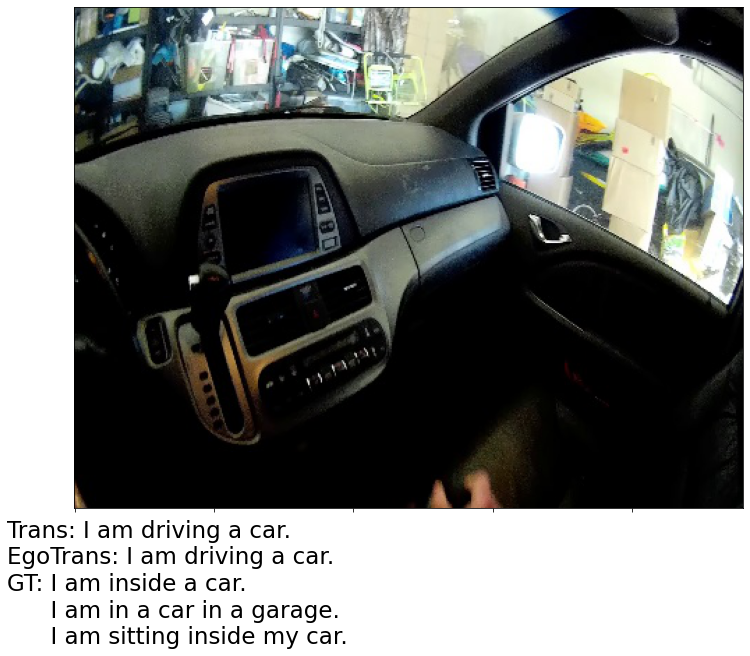

In [297]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 9), constrained_layout=True)

ax.set_xlabel("Trans: " + base_dict[sample_name][0].capitalize() +
              '\n' + "EgoTrans: " + cap_dict[sample_name][0].capitalize() +
              '\n' + "GT: " + gts[sample_name][0] +
              '\n' + "      " + gts[sample_name][1] +
              '\n' + "      " + gts[sample_name][2],
              fontsize=23, horizontalalignment='left', x=-0.1,
              #fontdict=dict(weight='bold')
             )

plt.imshow(image)
#ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().get_yaxis().set_visible(False)

fig.savefig(join('images', 'EgoEval', sample_path.split("/")[-1]), facecolor='w', bbox_inches='tight')

plt.show()